# LSTM using augmented data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.contrib import rnn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Masking, Embedding

C:\Users\Sam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\Sam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\Sam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\Sam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be unders

Data is read in as a pre-cleaned file cut down to the required time-frame and including the features to be used. Details of the data wrangling and the original dataset provided elsewhere.

In [2]:
gldata = pd.read_csv('C:/Users/Sam/Documents/ML4EnvEng/Project_Data/GLDData/data/clean/df_aug.csv')
gldata.head()

,Unnamed: 0,clouds,hur_ice,mi_ice,land_temp,lake_temp,wind,lake_mm,land_mm,inflow,chicago,outflow,wse,time_derivative
0,0,71.83,31.27,26.17,-5.97,-4.08,7.73,42.9,44.2,2120.0,75.0,5860.0,176.98,39.745553
1,1,73.45,68.11,36.97,-7.86,-6.04,7.07,33.9,33.5,1610.0,56.0,5490.0,176.95,103.057722
2,2,75.43,57.04,22.22,3.07,3.36,5.44,64.4,72.4,1500.0,130.0,5690.0,176.98,-224.917383
3,3,68.06,6.88,0.00,5.87,5.80,5.70,70.5,69.2,1560.0,128.0,6060.0,177.10,-38.395923
4,4,69.83,0.00,0.00,10.46,10.07,4.73,120.6,124.9,1560.0,112.0,6260.0,177.20,-28.525448


In [3]:
gldata.shape

(2736, 14)

In [4]:
x = ['clouds','mi_ice','hur_ice','land_temp','lake_temp','wind','lake_mm','land_mm','inflow','outflow','chicago']
y = ['wse']

In [5]:
gl_features = gldata[x].copy()
gl_labels = gldata[y].copy()

In [10]:
fig = px.scatter_matrix(gl_features,dimensions=x)
fig.update_layout(showlegend=False,
                  title_text="Feature Correlation",
                  title_x=0.1, height =1200, width = 1200)
fig.show()

In [7]:
pca = PCA()
components = pca.fit_transform(gl_features[x])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(components, labels = labels,dimensions = range(7))
fig.update_layout(showlegend=False,
                  title_text="PCA Covariation",
                  title_x=0.5, height =1000, width = 1000)
fig.show()

In [8]:
pca.fit(gl_features)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In [9]:
pca_features = pd.DataFrame(data = components)
pca_features.columns = ['pca1','pca2','pca3','pca4','pca5','pca6','pca7','pca8','pca9','pca10','pca11']

In [10]:
pca_ = ['pca1','pca2']
features = pca_features[pca_].copy()
features.head()

,pca1,pca2
0,362.418532,-192.172708
1,-221.343660,-431.356082
2,-107.013966,-630.135536
3,240.301576,-774.043880
4,411.025220,-878.867130


In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, gl_labels, test_size=0.25, random_state=324)
X_train.head()

,pca1,pca2
684,-104.958359,261.077343
2383,712.333939,362.302323
563,-358.823208,-722.275843
1656,22.036156,180.769760
1981,372.410568,201.554711


In [12]:
x_mean = X_train.mean(axis=0)
x_std = X_train.std(axis=0)
X_train = (X_train - x_mean) / x_std # (train_data - min) / (max-min) 
X_test = (X_test - x_mean) / x_std

X_train.head()

,pca1,pca2
684,-0.173868,0.771710
2383,1.172364,1.073820
563,-0.592030,-2.163138
1656,0.035316,0.532030
1981,0.612447,0.594063


In [13]:
print(X_train.shape,'\n',y_train.shape)

(2052, 2) 
 (2052, 1)


# Model Definition

In [14]:
X_train = X_train.values.reshape(1,2052,2)
y_train = y_train.values.reshape(1,2052,1)

In [15]:
print(X_train.shape,'\n',y_train.shape)

(1, 2052, 2) 
 (1, 2052, 1)


In [16]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer = 'adam', metrics=['mae'])

history = model.fit(X_train,y_train,epochs=1000,verbose=2)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/1000
1/1 - 4s - loss: 31226.4102 - mean_absolute_error: 176.7041
Epoch 2/1000
1/1 - 2s - loss: 31219.7520 - mean_absolute_error: 176.6853
Epoch 3/1000
1/1 - 2s - loss: 31212.5293 - mean_absolute_error: 176.6649
Epoch 4/1000
1/1 - 2s - loss: 31204.1523 - mean_absolute_error: 176.6412
Epoch 5/1000
1/1 - 2s - loss: 31194.0332 - mean_absolute_error: 176.6125
Epoch 6/1000
1/1 - 2s - loss: 31181.4980 - mean_absolute_error: 176.5770
Epoch 7/1000
1/1 - 2s - loss: 31165.6113 - mean_absolute_error: 176.5321
Epoch 8/1000
1/1 - 2s - loss: 31144.9707 - mean_absolute_error: 176.4736
Epoch 9/1000
1/1 - 2s - loss: 31117.4160 - mean_absolute_error: 176.3955
Epoch 10/1000
1/1 - 2s - loss: 31079.5215 - mean_absolute_error: 176.2880
Epoch 11/1000
1/1 - 2s - loss: 31025.7266 - mean_absolute

1/1 - 2s - loss: 25894.3262 - mean_absolute_error: 160.9091
Epoch 103/1000
1/1 - 2s - loss: 25871.4902 - mean_absolute_error: 160.8380
Epoch 104/1000
1/1 - 2s - loss: 25848.7070 - mean_absolute_error: 160.7672
Epoch 105/1000
1/1 - 2s - loss: 25825.9570 - mean_absolute_error: 160.6965
Epoch 106/1000
1/1 - 2s - loss: 25803.2656 - mean_absolute_error: 160.6258
Epoch 107/1000
1/1 - 2s - loss: 25780.6055 - mean_absolute_error: 160.5552
Epoch 108/1000
1/1 - 2s - loss: 25758.0000 - mean_absolute_error: 160.4848
Epoch 109/1000
1/1 - 2s - loss: 25735.4395 - mean_absolute_error: 160.4145
Epoch 110/1000
1/1 - 2s - loss: 25712.9258 - mean_absolute_error: 160.3443
Epoch 111/1000
1/1 - 2s - loss: 25690.4492 - mean_absolute_error: 160.2742
Epoch 112/1000
1/1 - 2s - loss: 25668.0195 - mean_absolute_error: 160.2042
Epoch 113/1000
1/1 - 2s - loss: 25645.6309 - mean_absolute_error: 160.1343
Epoch 114/1000
1/1 - 2s - loss: 25623.2891 - mean_absolute_error: 160.0645
Epoch 115/1000
1/1 - 2s - loss: 25600.98

Epoch 212/1000
1/1 - 2s - loss: 23579.2559 - mean_absolute_error: 153.5460
Epoch 213/1000
1/1 - 2s - loss: 23559.5195 - mean_absolute_error: 153.4816
Epoch 214/1000
1/1 - 2s - loss: 23539.7910 - mean_absolute_error: 153.4174
Epoch 215/1000
1/1 - 2s - loss: 23520.0918 - mean_absolute_error: 153.3532
Epoch 216/1000
1/1 - 2s - loss: 23500.4004 - mean_absolute_error: 153.2889
Epoch 217/1000
1/1 - 2s - loss: 23480.7344 - mean_absolute_error: 153.2248
Epoch 218/1000
1/1 - 2s - loss: 23461.0781 - mean_absolute_error: 153.1606
Epoch 219/1000
1/1 - 2s - loss: 23441.4453 - mean_absolute_error: 153.0965
Epoch 220/1000
1/1 - 2s - loss: 23421.8281 - mean_absolute_error: 153.0324
Epoch 221/1000
1/1 - 2s - loss: 23402.2285 - mean_absolute_error: 152.9684
Epoch 222/1000
1/1 - 2s - loss: 23382.6523 - mean_absolute_error: 152.9043
Epoch 223/1000
1/1 - 2s - loss: 23363.0859 - mean_absolute_error: 152.8403
Epoch 224/1000
1/1 - 2s - loss: 23343.5391 - mean_absolute_error: 152.7764
Epoch 225/1000
1/1 - 2s -

Epoch 322/1000
1/1 - 2s - loss: 21503.8086 - mean_absolute_error: 146.6314
Epoch 323/1000
1/1 - 2s - loss: 21485.7422 - mean_absolute_error: 146.5697
Epoch 324/1000
1/1 - 2s - loss: 21467.6953 - mean_absolute_error: 146.5082
Epoch 325/1000
1/1 - 2s - loss: 21449.6602 - mean_absolute_error: 146.4466
Epoch 326/1000
1/1 - 2s - loss: 21431.6367 - mean_absolute_error: 146.3851
Epoch 327/1000
1/1 - 2s - loss: 21413.6250 - mean_absolute_error: 146.3235
Epoch 328/1000
1/1 - 2s - loss: 21395.6328 - mean_absolute_error: 146.2620
Epoch 329/1000
1/1 - 2s - loss: 21377.6484 - mean_absolute_error: 146.2005
Epoch 330/1000
1/1 - 2s - loss: 21359.6758 - mean_absolute_error: 146.1391
Epoch 331/1000
1/1 - 2s - loss: 21341.7148 - mean_absolute_error: 146.0776
Epoch 332/1000
1/1 - 2s - loss: 21323.7734 - mean_absolute_error: 146.0162
Epoch 333/1000
1/1 - 2s - loss: 21305.8418 - mean_absolute_error: 145.9548
Epoch 334/1000
1/1 - 2s - loss: 21287.9258 - mean_absolute_error: 145.8933
Epoch 335/1000
1/1 - 2s -

Epoch 432/1000
1/1 - 2s - loss: 19593.1055 - mean_absolute_error: 139.9642
Epoch 433/1000
1/1 - 2s - loss: 19576.4121 - mean_absolute_error: 139.9045
Epoch 434/1000
1/1 - 2s - loss: 19559.7207 - mean_absolute_error: 139.8448
Epoch 435/1000
1/1 - 2s - loss: 19543.0430 - mean_absolute_error: 139.7852
Epoch 436/1000
1/1 - 2s - loss: 19526.3848 - mean_absolute_error: 139.7255
Epoch 437/1000
1/1 - 2s - loss: 19509.7266 - mean_absolute_error: 139.6659
Epoch 438/1000
1/1 - 2s - loss: 19493.0859 - mean_absolute_error: 139.6063
Epoch 439/1000
1/1 - 2s - loss: 19476.4551 - mean_absolute_error: 139.5468
Epoch 440/1000
1/1 - 2s - loss: 19459.8398 - mean_absolute_error: 139.4872
Epoch 441/1000
1/1 - 2s - loss: 19443.2285 - mean_absolute_error: 139.4277
Epoch 442/1000
1/1 - 2s - loss: 19426.6348 - mean_absolute_error: 139.3681
Epoch 443/1000
1/1 - 2s - loss: 19410.0449 - mean_absolute_error: 139.3086
Epoch 444/1000
1/1 - 2s - loss: 19393.4727 - mean_absolute_error: 139.2491
Epoch 445/1000
1/1 - 2s -

Epoch 542/1000
1/1 - 2s - loss: 17823.0000 - mean_absolute_error: 133.4907
Epoch 543/1000
1/1 - 2s - loss: 17807.5059 - mean_absolute_error: 133.4327
Epoch 544/1000
1/1 - 2s - loss: 17792.0352 - mean_absolute_error: 133.3747
Epoch 545/1000
1/1 - 2s - loss: 17776.5625 - mean_absolute_error: 133.3166
Epoch 546/1000
1/1 - 2s - loss: 17761.1055 - mean_absolute_error: 133.2587
Epoch 547/1000
1/1 - 2s - loss: 17745.6621 - mean_absolute_error: 133.2007
Epoch 548/1000
1/1 - 2s - loss: 17730.2246 - mean_absolute_error: 133.1428
Epoch 549/1000
1/1 - 2s - loss: 17714.8027 - mean_absolute_error: 133.0848
Epoch 550/1000
1/1 - 2s - loss: 17699.3926 - mean_absolute_error: 133.0269
Epoch 551/1000
1/1 - 2s - loss: 17683.9805 - mean_absolute_error: 132.9690
Epoch 552/1000
1/1 - 2s - loss: 17668.5898 - mean_absolute_error: 132.9111
Epoch 553/1000
1/1 - 2s - loss: 17653.2109 - mean_absolute_error: 132.8532
Epoch 554/1000
1/1 - 2s - loss: 17637.8320 - mean_absolute_error: 132.7953
Epoch 555/1000
1/1 - 2s -

Epoch 652/1000
1/1 - 2s - loss: 16180.6016 - mean_absolute_error: 127.1900
Epoch 653/1000
1/1 - 2s - loss: 16166.2266 - mean_absolute_error: 127.1334
Epoch 654/1000
1/1 - 2s - loss: 16151.8525 - mean_absolute_error: 127.0769
Epoch 655/1000
1/1 - 2s - loss: 16137.4980 - mean_absolute_error: 127.0204
Epoch 656/1000
1/1 - 2s - loss: 16123.1426 - mean_absolute_error: 126.9639
Epoch 657/1000
1/1 - 2s - loss: 16108.8057 - mean_absolute_error: 126.9074
Epoch 658/1000
1/1 - 2s - loss: 16094.4727 - mean_absolute_error: 126.8509
Epoch 659/1000
1/1 - 2s - loss: 16080.1533 - mean_absolute_error: 126.7945
Epoch 660/1000
1/1 - 2s - loss: 16065.8418 - mean_absolute_error: 126.7380
Epoch 661/1000
1/1 - 2s - loss: 16051.5410 - mean_absolute_error: 126.6816
Epoch 662/1000
1/1 - 2s - loss: 16037.2520 - mean_absolute_error: 126.6252
Epoch 663/1000
1/1 - 2s - loss: 16022.9629 - mean_absolute_error: 126.5687
Epoch 664/1000
1/1 - 2s - loss: 16008.6895 - mean_absolute_error: 126.5123
Epoch 665/1000
1/1 - 2s -

Epoch 762/1000
1/1 - 2s - loss: 14655.8730 - mean_absolute_error: 121.0475
Epoch 763/1000
1/1 - 2s - loss: 14642.5303 - mean_absolute_error: 120.9924
Epoch 764/1000
1/1 - 2s - loss: 14629.1953 - mean_absolute_error: 120.9372
Epoch 765/1000
1/1 - 2s - loss: 14615.8662 - mean_absolute_error: 120.8821
Epoch 766/1000
1/1 - 2s - loss: 14602.5498 - mean_absolute_error: 120.8270
Epoch 767/1000
1/1 - 2s - loss: 14589.2461 - mean_absolute_error: 120.7720
Epoch 768/1000
1/1 - 2s - loss: 14575.9443 - mean_absolute_error: 120.7169
Epoch 769/1000
1/1 - 2s - loss: 14562.6562 - mean_absolute_error: 120.6618
Epoch 770/1000
1/1 - 2s - loss: 14549.3760 - mean_absolute_error: 120.6068
Epoch 771/1000
1/1 - 2s - loss: 14536.1035 - mean_absolute_error: 120.5518
Epoch 772/1000
1/1 - 2s - loss: 14522.8398 - mean_absolute_error: 120.4967
Epoch 773/1000
1/1 - 2s - loss: 14509.5889 - mean_absolute_error: 120.4417
Epoch 774/1000
1/1 - 2s - loss: 14496.3428 - mean_absolute_error: 120.3867
Epoch 775/1000
1/1 - 2s -

Epoch 872/1000
1/1 - 2s - loss: 13241.7988 - mean_absolute_error: 115.0581
Epoch 873/1000
1/1 - 2s - loss: 13229.4268 - mean_absolute_error: 115.0043
Epoch 874/1000
1/1 - 2s - loss: 13217.0703 - mean_absolute_error: 114.9505
Epoch 875/1000
1/1 - 2s - loss: 13204.7197 - mean_absolute_error: 114.8968
Epoch 876/1000
1/1 - 2s - loss: 13192.3770 - mean_absolute_error: 114.8431
Epoch 877/1000
1/1 - 2s - loss: 13180.0420 - mean_absolute_error: 114.7894
Epoch 878/1000
1/1 - 2s - loss: 13167.7207 - mean_absolute_error: 114.7357
Epoch 879/1000
1/1 - 2s - loss: 13155.4014 - mean_absolute_error: 114.6820
Epoch 880/1000
1/1 - 2s - loss: 13143.0947 - mean_absolute_error: 114.6283
Epoch 881/1000
1/1 - 2s - loss: 13130.7949 - mean_absolute_error: 114.5746
Epoch 882/1000
1/1 - 2s - loss: 13118.5020 - mean_absolute_error: 114.5210
Epoch 883/1000
1/1 - 2s - loss: 13106.2217 - mean_absolute_error: 114.4673
Epoch 884/1000
1/1 - 2s - loss: 13093.9512 - mean_absolute_error: 114.4137
Epoch 885/1000
1/1 - 2s -

Epoch 982/1000
1/1 - 2s - loss: 11931.8242 - mean_absolute_error: 109.2169
Epoch 983/1000
1/1 - 2s - loss: 11920.3779 - mean_absolute_error: 109.1644
Epoch 984/1000
1/1 - 2s - loss: 11908.9346 - mean_absolute_error: 109.1120
Epoch 985/1000
1/1 - 2s - loss: 11897.4990 - mean_absolute_error: 109.0596
Epoch 986/1000
1/1 - 2s - loss: 11886.0723 - mean_absolute_error: 109.0072
Epoch 987/1000
1/1 - 2s - loss: 11874.6553 - mean_absolute_error: 108.9548
Epoch 988/1000
1/1 - 2s - loss: 11863.2412 - mean_absolute_error: 108.9024
Epoch 989/1000
1/1 - 2s - loss: 11851.8428 - mean_absolute_error: 108.8501
Epoch 990/1000
1/1 - 2s - loss: 11840.4473 - mean_absolute_error: 108.7977
Epoch 991/1000
1/1 - 2s - loss: 11829.0596 - mean_absolute_error: 108.7453
Epoch 992/1000
1/1 - 2s - loss: 11817.6816 - mean_absolute_error: 108.6930
Epoch 993/1000
1/1 - 2s - loss: 11806.3115 - mean_absolute_error: 108.6407
Epoch 994/1000
1/1 - 2s - loss: 11794.9492 - mean_absolute_error: 108.5884
Epoch 995/1000
1/1 - 2s -

# Evaluation

In [19]:
X_test.shape

(684, 2)

In [20]:
y_test.shape

(684, 1)

In [21]:
X_test = X_test.values.reshape(1,684,2)
y_test = y_test.values.reshape(1,684,1)

In [22]:
[loss, mae] = model.evaluate(X_test, y_test, verbose=0)

In [23]:
print(mae)

108.26829


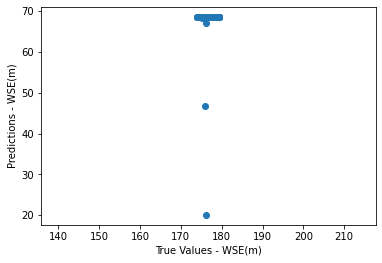

In [26]:
test_predictions = model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values - WSE(m)')
plt.ylabel('Predictions - WSE(m)')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])
plt.savefig('C:/Users/Sam/Documents/ML4EnvEng/LSTMAug.png')